# Shoe Training via Same CNN Pipeline as Clothing

In [108]:
# %load_ext autoreload
# %reload_ext autoreload

import numpy as np
from glob import glob

# import necessary keras modules
from keras.preprocessing import image 
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping  
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

# custom functions
from layer_output import get_dense_layers, path_to_tensor, paths_to_tensor
from loading import load_files       

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path, ignore_files='.DS_Store')
    shoe_files = np.array(data['filenames'])
    shoe_targets = np_utils.to_categorical(np.array(data['target']), 9)
    return shoe_files, shoe_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../data/shoes/train')
valid_files, valid_targets = load_dataset('../data/shoes/validate')
test_files, test_targets = load_dataset('../data/shoes/test')

# load list of clothing names
shoe_names = [item[20:-1] for item in sorted(glob("../data/shoes/train/*/"))]

# print info about the dataset
print(f'There are {len(shoe_names)} total shoe categories.')
print(f'There are {len(np.hstack([train_files, valid_files, test_files]))} total shoe images.\n')
print(f'There are {len(train_files)} training shoe images.')
print(f'There are {len(valid_files)} validation shoe images.')
print(f'There are {len(test_files)} test shoe images.')

There are 9 total shoe categories.
There are 24674 total shoe images.

There are 19975 training shoe images.
There are 2473 validation shoe images.
There are 2226 test shoe images.


In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
# rescale the images by dividing every pixel in every image by 255.
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 2226/2226 [00:03<00:00, 712.69it/s]


## Build the CNN Architechture

In [10]:
model = Sequential()

# Define the architecture.
model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=5, strides=2, padding='valid', activation='relu', 
                 input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=5, strides=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(rate=0.3))
model.add(Conv2D(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())

model.add(Dense(units=300, activation='relu', name='vectors')) # extract vectors from here and cluster
model.add(Dropout(rate=0.3))
model.add(Dense(len(shoe_names), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 110, 110, 16)      1216      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)        12832     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 6, 6, 64)          8256      
__________

In [11]:
# compile the model 
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [7]:
# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

datagen_train.fit(train_tensors)

In [12]:
epochs = 30

early_stop = EarlyStopping(monitor='val_loss', patience=4)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_shoes.hdf5', 
                               verbose=1, save_best_only=True)
history = model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=32, callbacks=[checkpointer, early_stop], verbose=1)


Train on 19975 samples, validate on 2473 samples
Epoch 1/20
19975/19975 [==============================] - 168s 8ms/step - loss: 1.2573 - acc: 0.5324 - val_loss: 0.8824 - val_acc: 0.6915

Epoch 00001: val_loss improved from inf to 0.88237, saving model to saved_models/weights.best.from_scratch_shoes.hdf5
Epoch 2/20
19975/19975 [==============================] - 156s 8ms/step - loss: 0.8595 - acc: 0.6902 - val_loss: 0.6743 - val_acc: 0.7594

Epoch 00002: val_loss improved from 0.88237 to 0.67434, saving model to saved_models/weights.best.from_scratch_shoes.hdf5
Epoch 3/20
19975/19975 [==============================] - 151s 8ms/step - loss: 0.7659 - acc: 0.7270 - val_loss: 0.6284 - val_acc: 0.7727

Epoch 00003: val_loss improved from 0.67434 to 0.62837, saving model to saved_models/weights.best.from_scratch_shoes.hdf5
Epoch 4/20
19975/19975 [==============================] - 151s 8ms/step - loss: 0.6995 - acc: 0.7514 - val_loss: 0.6030 - val_acc: 0.7820

Epoch 00004: val_loss improved fr

## Graph of training/validation Accuracy and Loss

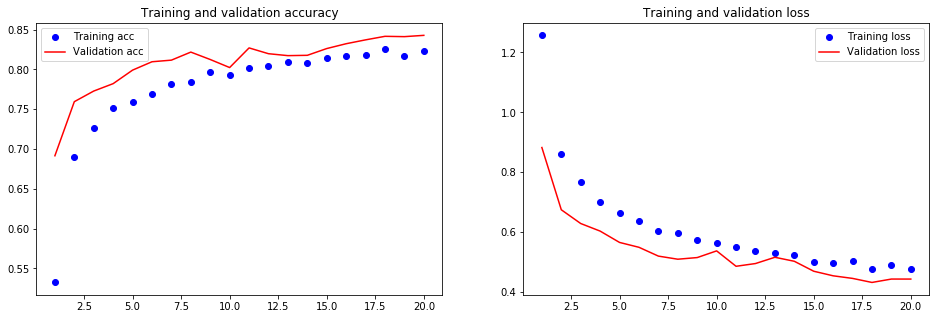

In [105]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', c='r')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', c='r')
plt.title('Training and validation loss')
plt.legend();

In [14]:
# get index of predicted item for each image in test set
shoe_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(shoe_predictions)==np.argmax(test_targets, axis=1))/len(shoe_predictions)
print('Test accuracy: {}'.format(round(test_accuracy, 4)))

Test accuracy: 82.929


In [15]:
# https://towardsdatascience.com/visualizing-intermediate-activation-in-convolutional
# -neural-networks-with-keras-260b36d60d0
model.save('saved_models/shoes_cnn.h5')
# load the model with best validation loss
model.load_weights('saved_models/weights.best.from_scratch_shoes.hdf5')


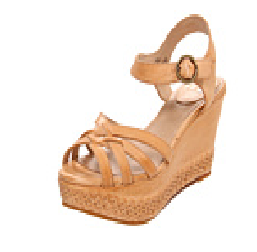

Predicted class: sandals


In [100]:
img_path = '../data/shoes/test/sandals/7910998.332551.jpg'
img_tensor = path_to_tensor(img_path)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show();

image = np.vstack([img_tensor])
classes = model.predict_classes(image)
print("Predicted class:", shoe_names[int(classes)])

## Get a matrix of all images Dense layer stacked

In [110]:
train_files[:5]

array(['../data/shoes/train/heels/8043038.316039.jpg',
       '../data/shoes/train/heels/8083287.632.jpg',
       '../data/shoes/train/sandals/8078932.93554.jpg',
       '../data/shoes/train/athletic/7648281.366976.jpg',
       '../data/shoes/train/calf_boots/7697146.3008.jpg'], dtype='<U50')

In [113]:
import pickle
all_clothing_paths = np.append(train_files, np.append(valid_files, test_files))

dense_layers, dense_df = get_dense_layers(model, all_clothing_paths)
pickle.dump(dense_df, open("saved_models/dense_shoe_df.pickle", "wb" ))
print(dense_layers.shape)
print(dense_df.shape)
dense_df.head()

(24674, 150)
(24674, 150)


,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
../data/shoes/train/heels/8043038.316039.jpg,-0.0,-0.000000,-0.000000,-0.000000,0.623390,2.524577,-0.0,-0.0,-0.000000,-0.0,...,0.044441,-0.000000,-0.0,0.007148,-0.0,0.823984,0.51745,0.887040,2.022019,-0.000000
../data/shoes/train/heels/8083287.632.jpg,-0.0,1.004132,-0.000000,-0.000000,2.914217,1.972810,-0.0,-0.0,-0.000000,-0.0,...,-0.000000,1.379579,-0.0,2.108707,-0.0,-0.000000,-0.00000,1.453297,0.977426,-0.000000
../data/shoes/train/sandals/8078932.93554.jpg,-0.0,2.433344,-0.000000,-0.000000,3.276672,2.675798,-0.0,-0.0,-0.000000,-0.0,...,0.456098,-0.000000,-0.0,2.718879,-0.0,-0.000000,-0.00000,0.731049,0.324867,-0.000000
../data/shoes/train/athletic/7648281.366976.jpg,-0.0,-0.000000,0.565378,0.484051,1.656650,3.466596,-0.0,-0.0,0.957614,-0.0,...,1.389993,-0.000000,-0.0,0.212276,-0.0,0.086965,-0.00000,-0.000000,0.957823,-0.000000
../data/shoes/train/calf_boots/7697146.3008.jpg,-0.0,-0.000000,-0.000000,-0.000000,1.476679,1.689637,-0.0,-0.0,-0.000000,-0.0,...,-0.000000,-0.000000,-0.0,-0.000000,-0.0,-0.000000,-0.00000,0.317774,1.782560,1.406268


### K-Means cluster graph

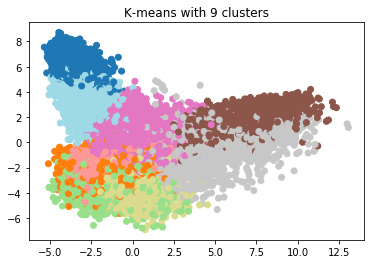

In [115]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pylab as pl

X = dense_layers
pca = PCA(n_components=2).fit(X)
pca_2d = pca.transform(X)
kmeans = KMeans(n_clusters=9, random_state=11)
kmeans.fit(X)
pl.figure()
pl.title('K-means with 9 clusters')
pl.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, cmap='tab20');

### T-SNE Graph

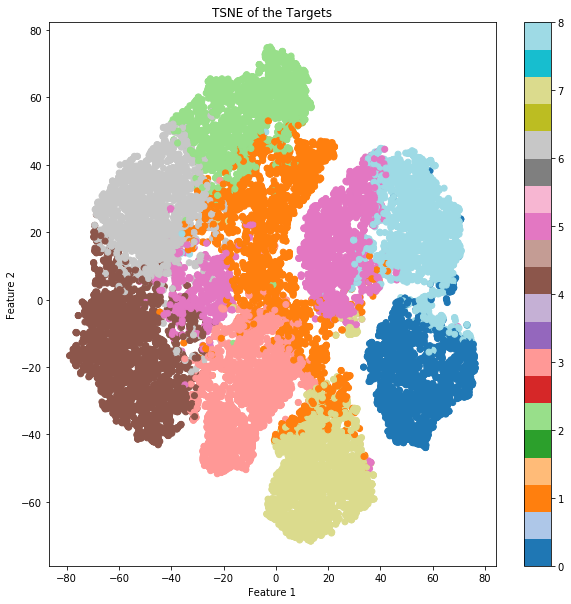

In [116]:
# https://datascience.stackexchange.com/questions/31700/how-to-print-kmeans-cluster-python
from sklearn.manifold import TSNE

# Embed the features into 2 features using TSNE
X_embedded_tsne = TSNE(n_components=2, perplexity=25).fit_transform(X)

plt.figure(figsize=(15,15))
plt.scatter(X_embedded_tsne[:,0], X_embedded_tsne[:,1], c = kmeans.labels_, cmap='tab20')
plt.title('TSNE of the Targets')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show();
# plt.tight_layout();

**Assign each file to a cluster**

In [117]:
# Assign each training file to a cluster for understanding the clusters and troubleshooting
for cluster_num in range(9):
    mask = np.where(kmeans.labels_ == cluster_num)[0]
    for idx in mask:
        print(f"Image {all_clothing_paths[idx]} is in cluster: {cluster_num}")

Image ../data/shoes/train/calf_boots/7669761.3.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/8029561.106.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/7647921.665.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/7341112.272342.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/8003538.352766.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/8012715.3.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/7348548.73338.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/8046538.6.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/7992449.16158.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/8013843.652.jpg is in cluster: 0
Image ../data/shoes/train/calf_boots/8059906.383259.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/7971364.353113.jpg is in cluster: 0
Image ../data/shoes/train/calf_boots/8024625.77673.jpg is in cluster: 0
Image ../data/shoes/train/knee_boots/8025564.23562.jpg is in cluster: 0
Image 

Image ../data/shoes/test/calf_boots/7655266.17498.jpg is in cluster: 0
Image ../data/shoes/test/knee_boots/8004712.3.jpg is in cluster: 0
Image ../data/shoes/test/knee_boots/8053880.106.jpg is in cluster: 0
Image ../data/shoes/test/calf_boots/8050802.106.jpg is in cluster: 0
Image ../data/shoes/test/knee_boots/8012215.72.jpg is in cluster: 0
Image ../data/shoes/test/knee_boots/8036357.153504.jpg is in cluster: 0
Image ../data/shoes/test/knee_boots/8013592.3.jpg is in cluster: 0
Image ../data/shoes/test/calf_boots/7991155.585.jpg is in cluster: 0
Image ../data/shoes/test/knee_boots/7963305.3.jpg is in cluster: 0
Image ../data/shoes/test/knee_boots/8051014.106.jpg is in cluster: 0
Image ../data/shoes/test/knee_boots/8015495.368179.jpg is in cluster: 0
Image ../data/shoes/test/calf_boots/8000953.278.jpg is in cluster: 0
Image ../data/shoes/test/knee_boots/7561043.1802.jpg is in cluster: 0
Image ../data/shoes/test/knee_boots/7990538.3877.jpg is in cluster: 0
Image ../data/shoes/test/knee_b

Image ../data/shoes/train/sandals/8038171.127028.jpg is in cluster: 1
Image ../data/shoes/train/backless/7789401.288239.jpg is in cluster: 1
Image ../data/shoes/train/flats/7834962.2362.jpg is in cluster: 1
Image ../data/shoes/train/athletic/7813660.6700.jpg is in cluster: 1
Image ../data/shoes/train/backless/7747195.401.jpg is in cluster: 1
Image ../data/shoes/train/sandals/7996552.18.jpg is in cluster: 1
Image ../data/shoes/train/heels/7849338.106.jpg is in cluster: 1
Image ../data/shoes/train/sandals/7950587.72.jpg is in cluster: 1
Image ../data/shoes/train/sandals/7911724.552.jpg is in cluster: 1
Image ../data/shoes/train/sandals/7904650.151.jpg is in cluster: 1
Image ../data/shoes/train/sandals/7213012.216467.jpg is in cluster: 1
Image ../data/shoes/train/sandals/7875385.315301.jpg is in cluster: 1
Image ../data/shoes/train/backless/7391653.15.jpg is in cluster: 1
Image ../data/shoes/train/athletic/7813186.6.jpg is in cluster: 1
Image ../data/shoes/train/backless/7719052.3.jpg is 

Image ../data/shoes/train/sandals/8089886.18.jpg is in cluster: 2
Image ../data/shoes/train/sandals/8080017.314.jpg is in cluster: 2
Image ../data/shoes/train/sandals/7833144.3.jpg is in cluster: 2
Image ../data/shoes/train/sandals/8112748.535.jpg is in cluster: 2
Image ../data/shoes/train/sandals/7557464.183092.jpg is in cluster: 2
Image ../data/shoes/train/sandals/123303.20202.jpg is in cluster: 2
Image ../data/shoes/train/sandals/7280540.332843.jpg is in cluster: 2
Image ../data/shoes/train/sandals/8089594.200.jpg is in cluster: 2
Image ../data/shoes/train/sandals/7777898.365070.jpg is in cluster: 2
Image ../data/shoes/train/sandals/8064057.14754.jpg is in cluster: 2
Image ../data/shoes/train/sandals/7409732.385942.jpg is in cluster: 2
Image ../data/shoes/train/sandals/7385739.3.jpg is in cluster: 2
Image ../data/shoes/train/sandals/7639875.72.jpg is in cluster: 2
Image ../data/shoes/train/sandals/8080625.1897.jpg is in cluster: 2
Image ../data/shoes/train/sandals/7894011.712.jpg is

Image ../data/shoes/train/flats/8055627.89.jpg is in cluster: 3
Image ../data/shoes/train/flats/7976761.355878.jpg is in cluster: 3
Image ../data/shoes/train/flats/7648411.2467.jpg is in cluster: 3
Image ../data/shoes/train/athletic/7909937.607.jpg is in cluster: 3
Image ../data/shoes/train/flats/7977426.278.jpg is in cluster: 3
Image ../data/shoes/train/heels/7420012.665.jpg is in cluster: 3
Image ../data/shoes/train/flats/8104157.585.jpg is in cluster: 3
Image ../data/shoes/train/heels/8113417.52.jpg is in cluster: 3
Image ../data/shoes/train/flats/7189716.360899.jpg is in cluster: 3
Image ../data/shoes/train/flats/8051097.48492.jpg is in cluster: 3
Image ../data/shoes/train/athletic/8146850.415835.jpg is in cluster: 3
Image ../data/shoes/train/heels/8037398.212522.jpg is in cluster: 3
Image ../data/shoes/train/flats/7970521.248971.jpg is in cluster: 3
Image ../data/shoes/train/flats/7648411.332557.jpg is in cluster: 3
Image ../data/shoes/train/heels/7842126.80012.jpg is in cluster: 

Image ../data/shoes/test/athletic/8127055.20455.jpg is in cluster: 3
Image ../data/shoes/test/flats/8022863.367909.jpg is in cluster: 3
Image ../data/shoes/test/flats/7919678.764.jpg is in cluster: 3
Image ../data/shoes/test/athletic/7764667.281377.jpg is in cluster: 3
Image ../data/shoes/test/flats/7811075.41726.jpg is in cluster: 3
Image ../data/shoes/test/flats/8046555.13879.jpg is in cluster: 3
Image ../data/shoes/test/flats/8092173.24132.jpg is in cluster: 3
Image ../data/shoes/test/flats/7794340.1430.jpg is in cluster: 3
Image ../data/shoes/test/flats/7874781.307257.jpg is in cluster: 3
Image ../data/shoes/test/flats/8015521.368203.jpg is in cluster: 3
Image ../data/shoes/test/flats/8075961.392935.jpg is in cluster: 3
Image ../data/shoes/test/flats/8016197.368431.jpg is in cluster: 3
Image ../data/shoes/test/flats/7874781.393121.jpg is in cluster: 3
Image ../data/shoes/test/flats/8060929.20704.jpg is in cluster: 3
Image ../data/shoes/test/flats/8061995.247339.jpg is in cluster: 3

Image ../data/shoes/train/heels/8109587.72.jpg is in cluster: 4
Image ../data/shoes/train/heels/8081039.36520.jpg is in cluster: 4
Image ../data/shoes/train/heels/8098772.3.jpg is in cluster: 4
Image ../data/shoes/train/heels/8031435.81034.jpg is in cluster: 4
Image ../data/shoes/train/heels/7999480.106.jpg is in cluster: 4
Image ../data/shoes/train/heels/8113598.79779.jpg is in cluster: 4
Image ../data/shoes/train/heels/8111315.215834.jpg is in cluster: 4
Image ../data/shoes/train/heels/8076659.72.jpg is in cluster: 4
Image ../data/shoes/train/heels/7953108.321317.jpg is in cluster: 4
Image ../data/shoes/train/heels/8034712.632.jpg is in cluster: 4
Image ../data/shoes/train/heels/8021327.585.jpg is in cluster: 4
Image ../data/shoes/train/heels/8038979.72.jpg is in cluster: 4
Image ../data/shoes/train/heels/7630802.245988.jpg is in cluster: 4
Image ../data/shoes/train/heels/8067318.386710.jpg is in cluster: 4
Image ../data/shoes/train/heels/7490059.409130.jpg is in cluster: 4
Image ../

Image ../data/shoes/train/ankle_boots/8045204.377625.jpg is in cluster: 5
Image ../data/shoes/train/ankle_boots/7886661.324354.jpg is in cluster: 5
Image ../data/shoes/train/heels/8030294.711.jpg is in cluster: 5
Image ../data/shoes/train/ankle_boots/8010744.3.jpg is in cluster: 5
Image ../data/shoes/train/athletic/7819450.300810.jpg is in cluster: 5
Image ../data/shoes/train/heels/8067781.1984.jpg is in cluster: 5
Image ../data/shoes/train/ankle_boots/7583079.82199.jpg is in cluster: 5
Image ../data/shoes/train/heels/8006900.72.jpg is in cluster: 5
Image ../data/shoes/train/heels/8110075.183092.jpg is in cluster: 5
Image ../data/shoes/train/heels/8046505.53227.jpg is in cluster: 5
Image ../data/shoes/train/ankle_boots/7805462.654.jpg is in cluster: 5
Image ../data/shoes/train/calf_boots/7996654.363027.jpg is in cluster: 5
Image ../data/shoes/train/ankle_boots/7999324.60.jpg is in cluster: 5
Image ../data/shoes/train/ankle_boots/8051683.72.jpg is in cluster: 5
Image ../data/shoes/train

Image ../data/shoes/train/sandals/7934612.3.jpg is in cluster: 6
Image ../data/shoes/train/sandals/7627324.68.jpg is in cluster: 6
Image ../data/shoes/train/sandals/7894170.91889.jpg is in cluster: 6
Image ../data/shoes/train/heels/8116572.404612.jpg is in cluster: 6
Image ../data/shoes/train/heels/8025895.3.jpg is in cluster: 6
Image ../data/shoes/train/heels/7523111.116051.jpg is in cluster: 6
Image ../data/shoes/train/sandals/8113505.403592.jpg is in cluster: 6
Image ../data/shoes/train/heels/8064958.376974.jpg is in cluster: 6
Image ../data/shoes/train/heels/8088887.2918.jpg is in cluster: 6
Image ../data/shoes/train/sandals/8099645.3.jpg is in cluster: 6
Image ../data/shoes/train/heels/7764126.3525.jpg is in cluster: 6
Image ../data/shoes/train/sandals/7991668.632.jpg is in cluster: 6
Image ../data/shoes/train/heels/7895804.303876.jpg is in cluster: 6
Image ../data/shoes/train/sandals/7922110.80183.jpg is in cluster: 6
Image ../data/shoes/train/heels/8083281.147958.jpg is in clust

Image ../data/shoes/train/athletic/7942209.864.jpg is in cluster: 7
Image ../data/shoes/train/athletic/7896049.363844.jpg is in cluster: 7
Image ../data/shoes/train/athletic/8069538.387944.jpg is in cluster: 7
Image ../data/shoes/train/athletic/7751698.276159.jpg is in cluster: 7
Image ../data/shoes/train/athletic/7386776.361437.jpg is in cluster: 7
Image ../data/shoes/train/athletic/7969922.6124.jpg is in cluster: 7
Image ../data/shoes/train/athletic/7936243.3.jpg is in cluster: 7
Image ../data/shoes/train/athletic/7707745.139.jpg is in cluster: 7
Image ../data/shoes/train/athletic/8030915.373604.jpg is in cluster: 7
Image ../data/shoes/train/athletic/7972016.385687.jpg is in cluster: 7
Image ../data/shoes/train/athletic/7708969.259527.jpg is in cluster: 7
Image ../data/shoes/train/athletic/8023501.371030.jpg is in cluster: 7
Image ../data/shoes/train/athletic/8046398.378189.jpg is in cluster: 7
Image ../data/shoes/train/athletic/8076030.2557.jpg is in cluster: 7
Image ../data/shoes/t

Image ../data/shoes/train/calf_boots/8039620.2754.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/7579977.171852.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/8010516.366578.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/8010868.325.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/7970312.301571.jpg is in cluster: 8
Image ../data/shoes/train/knee_boots/7363796.9.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/7956345.401.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/101191.3.jpg is in cluster: 8
Image ../data/shoes/train/ankle_boots/7575254.20.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/7561217.151.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/7549978.6865.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/7958800.155.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/7457769.324585.jpg is in cluster: 8
Image ../data/shoes/train/calf_boots/7970237.248964.jpg is in cluster: 8
Image ..

Image ../data/shoes/test/calf_boots/8076028.18.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/7919290.764.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/7578588.206804.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/8123918.3.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/8132057.68.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/7329412.4748.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/7912968.20.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/7670146.278.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/8167649.18.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/8000276.580.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/7608170.247984.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/8033560.2971.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/7997971.49185.jpg is in cluster: 8
Image ../data/shoes/test/calf_boots/7982968.289.jpg is in cluster: 8
Image ../data/shoes/test/calf_

In [118]:
# number of images in each cluster
[np.where(kmeans.labels_ == cluster_num, 1, 0).sum() for cluster_num in range(9)]

[2536, 3316, 2359, 2833, 3257, 2846, 2472, 2616, 2439]

**Confusion matrix of labels and clusters**

In [119]:
targets1 = np.array([np.where(target == 1)[0][0] for target in train_targets])
targets2 = np.array([np.where(target == 1)[0][0] for target in valid_targets])
targets3 = np.array([np.where(target == 1)[0][0] for target in test_targets])
targets = np.append(targets1, np.append(targets2, targets3))

In [122]:
# create a confusion matrix out of the the labels and clusters
confusion = dict()

for target, label in zip(targets, kmeans.labels_):
    confusion[(target, label)] = confusion.get((target, label), 0) + 1

for target in range(9):
    line = '  '.join([f'{confusion.get((target,label),0):4d}' for label in range(9)])
    print(line)    

   2    50     2     2     9  1879     2     9   452
   0   582     3   114     0    85     2  2579     9
   0   923    18    17     2   101     9     2     0
 675     8     0     0     0   104     0     0  1847
   0   479    32  2160     2     0     2    10     0
   1   162     7   454  3231   594  1142     5     6
1858     0     0     0     0     3     0     0   110
   0   637  2265    22    13    78  1315     8     7
   0   475    32    64     0     2     0     3     8


In [123]:
for i, name in enumerate(shoe_names):
    print(i,': ', name)

0 :  ankle_boots
1 :  athletic
2 :  backless
3 :  calf_boots
4 :  flats
5 :  heels
6 :  knee_boots
7 :  sandals
8 :  slippers
